In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import random
from imblearn.over_sampling import SMOTENC

from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

drive_path = '/content/drive/MyDrive/Kuliah/Tugas Akhir/Final Project Shared Folder'
data_path = "Dataset/Data Versioning/"
model_path = "Model/ML Model/"
data_version = "Trained_V2-3.csv"
base_url = "https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?CycleBeginYear=2017"
dataset_names = ['Demographics', 'Dietary', 'Examination', 'Laboratory', 'Questionnaire']

# Ingest Data

df_raw = pd.read_csv(os.path.join(drive_path, data_path+data_version), index_col = 0)
try:
  df_raw = df_raw.set_index('SEQN', drop=True)
  df_raw = df_raw.drop(columns = "Unnamed: 0")
except:
  pass

def get_categorical(df):
    categorical = []
    for col in df.columns.tolist():
        try:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': model_var[model_var['model_var_name'] ==  col]['desc'].values[0],
                    'column': col,
                    'possible_values': df[col].unique().tolist()}
                            )
        except Exception as error:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': None,
                    'column': col,
                    'possible_values': df[col].unique().tolist()})
            # print(f'{col} error: {error}')
    return categorical

X = df_raw.copy().drop(columns=['Quest16_MCQ160B'])
y = df_raw['Quest16_MCQ160B']

categorical_summary = get_categorical(X)
categorical_cols = [True if data_col in [col['column'] for col in categorical_summary] else False for data_col in X.columns.tolist()]
print(categorical_cols)

# Data Preparation For Model

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def prep_data(df):
  X = df_raw.copy().drop(columns=['Quest16_MCQ160B'])
  y = df_raw['Quest16_MCQ160B']

  y = y.replace({2: 0})
  y = y.replace({9: 0})

  y = y.astype(int)

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


  # Instantiate the SMOTE oversampler
  smotenc = SMOTENC(
      categorical_features=categorical_cols,
      sampling_strategy='auto',
      random_state=37
    )

  # Apply SMOTE to generate synthetic samples
  X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)

  scaler = StandardScaler()
  X_resampled = scaler.fit_transform(X_resampled)
  X_val = scaler.transform(X_val)

  # X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
  # X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

  print("Train: ", X_resampled.shape, " ", y_resampled.shape)
  print("Val: ", X_val.shape, " ", y_val.shape)
  print("Column Used: ", X.columns.tolist())

  return X_resampled, X_val, y_resampled, y_val

X_train, X_val, y_train, y_val = prep_data(df_raw)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, False, True, True, False, True, True, True, True, False, True, True, False, True, True, False, False, True, True, False, True, False, False, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True]
Train:  (7522, 85)   (7522,)
Val:  (1671, 85)   (1671,)
Column Used:  ['Dieta1_DRDINT', 'Dieta1_DR1TFIBE', 'Quest21_SLQ300', 'Quest19_PAD660', 'Quest19_PAQ635', 'Dieta1_DR1TCHOL', 'Quest19_PAQ655', 'Dieta1_DR1TSFAT', 'Dieta1_DR1TKCAL', 'Exami2_BMXBMI', 'Dieta1_DR1TSUGR', 'Quest21_SLQ320', 'Quest21_SLQ330', 'Quest19_PAD615', 'Quest21_SLD012', 'Quest21_SLD013', 'Dieta1_DR1DAY', 'Quest6_DED120', 'Quest19_PAQ610', 'Quest6_DED125', 'Dieta1_DR1TPROT', 'Quest19_PAQ640', 'Dieta

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score, roc_auc_score

rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train, y_train)

print("Train Score:")
print(rf_classifier.score(X_train, y_train))
print("Validation Score:")
print(rf_classifier.score(X_val, y_val))

y_pred = rf_classifier.predict(X_val)
print(classification_report(y_val, y_pred))


f1score = f1_score(y_val, y_pred, average='weighted')
roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

print("F1Score:", f1score)
print("ROC AUC:", roc_auc)

Train Score:
1.0
Validation Score:
0.959904248952723
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1607
           1       0.44      0.19      0.26        64

    accuracy                           0.96      1671
   macro avg       0.71      0.59      0.62      1671
weighted avg       0.95      0.96      0.95      1671

F1Score: 0.9519810820954454
ROC AUC: 0.5890829184816428


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Define the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Define the hyperparameters grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print("Hyperparameters:", params)
    print("Mean Score:", mean_score)
    print()

print("Best Params")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

print("Train Score:")
print(best_model.score(X_train, y_train))
print("Validation Score:")
print(best_model.score(X_val, y_val))

y_pred = best_model.predict(X_val)
print(classification_report(y_val, y_pred))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean Score: 0.9763413621262458

Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Score: 0.9767394147169011

Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Score: 0.975809358874673

Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Mean Score: 0.9763407436205556

Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mean Score: 0.9762080299710186

Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mean 

In [ ]:
np.random.seed(37)
random.seed(37)

worst_hyperparameters = grid_search.cv_results_['params'][np.argmax(grid_search.cv_results_['rank_test_score'] == np.max(grid_search.cv_results_['rank_test_score']))]

print("Worst Performing Hyperparameters:", worst_hyperparameters)

rf_classifier = RandomForestClassifier(**worst_hyperparameters)

rf_classifier.fit(X_train, y_train)

print("Train Score:")
print(rf_classifier.score(X_train, y_train))
print("Validation Score:")
print(rf_classifier.score(X_val, y_val))

y_pred = rf_classifier.predict(X_val)
print(classification_report(y_val, y_pred))

f1score = f1_score(y_val, y_pred, average='weighted')
roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

print("F1Score:", f1score)
print("ROC AUC:", roc_auc)

Worst Performing Hyperparameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Train Score:
0.978330231321457
Validation Score:
0.9365649311789348
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1607
           1       0.26      0.36      0.30        64

    accuracy                           0.94      1671
   macro avg       0.62      0.66      0.63      1671
weighted avg       0.95      0.94      0.94      1671

F1Score: 0.9413343357098305
ROC AUC: 0.6594634800871189


In [ ]:
np.random.seed(37)
random.seed(37)

best_hyperparameters = grid_search.cv_results_['params'][np.argmax(grid_search.cv_results_['rank_test_score'] == np.min(grid_search.cv_results_['rank_test_score']))]

print("Best Performing Hyperparameters:", best_hyperparameters)

rf_classifier = RandomForestClassifier(**best_hyperparameters)

rf_classifier.fit(X_train, y_train)

print("Train Score:")
print(rf_classifier.score(X_train, y_train))
print("Validation Score:")
print(rf_classifier.score(X_val, y_val))

y_pred = rf_classifier.predict(X_val)
print(classification_report(y_val, y_pred))

f1score = f1_score(y_val, y_pred, average='weighted')
roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

print("F1Score:", f1score)
print("ROC AUC:", roc_auc)

Best Performing Hyperparameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Train Score:
0.9986705663387397
Validation Score:
0.9581089168162776
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1607
           1       0.38      0.14      0.20        64

    accuracy                           0.96      1671
   macro avg       0.67      0.57      0.59      1671
weighted avg       0.94      0.96      0.95      1671

F1Score: 0.9488456904822784
ROC AUC: 0.5656454184816427


In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score, roc_auc_score


np.random.seed(37)
random.seed(37)

rf_classifier = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=1, min_samples_split=5, n_estimators=100)

rf_classifier.fit(X_train, y_train)

print("Train Score:")
print(rf_classifier.score(X_train, y_train))
print("Validation Score:")
print(rf_classifier.score(X_val, y_val))

y_pred = rf_classifier.predict(X_val)
print(classification_report(y_val, y_pred))

f1score = f1_score(y_val, y_pred, average='weighted')
roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

print("F1Score:", f1score)
print("ROC AUC:", roc_auc)

Train Score:
0.9986705663387397
Validation Score:
0.9581089168162776
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1607
           1       0.38      0.14      0.20        64

    accuracy                           0.96      1671
   macro avg       0.67      0.57      0.59      1671
weighted avg       0.94      0.96      0.95      1671

F1Score: 0.9488456904822784
ROC AUC: 0.5656454184816427


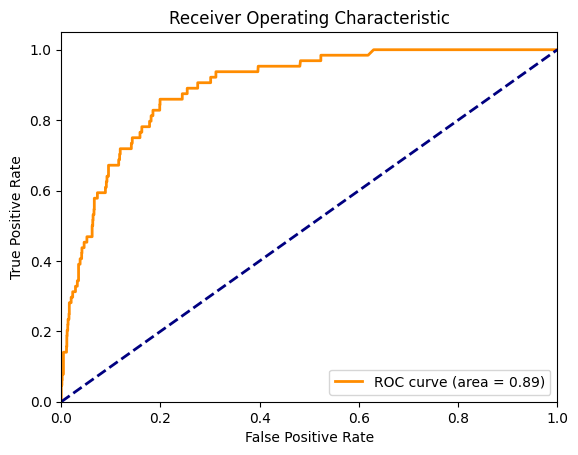

Optimal Threshold: 0.12233333333333335
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      1607
           1       0.15      0.86      0.25        64

    accuracy                           0.80      1671
   macro avg       0.57      0.83      0.57      1671
weighted avg       0.96      0.80      0.86      1671

ROC AUC Score: 0.8927494943995021


In [7]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

y_pred_prob = rf_classifier.predict_proba(X_val)[:, 1]

# Assuming y_val are the true labels and y_pred_prob are the predicted probabilities
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = roc_auc_score(y_val, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find the optimal threshold
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')

# Apply the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Evaluate performance at the optimal threshold
print(classification_report(y_val, y_pred_optimal))
print(f'ROC AUC Score: {roc_auc}')

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score


np.random.seed(37)
random.seed(37)

rf_classifier = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=1, min_samples_split=5, n_estimators=100)

rf_classifier.fit(X_train, y_train)

print("Train Score:")
print(rf_classifier.score(X_train, y_train))
print("Validation Score:")
print(rf_classifier.score(X_val, y_val))

y_proba = rf_classifier.predict_proba(X_val)
y_pred = [1 if preds[1] >= optimal_threshold else 0 for preds in y_proba]
print(classification_report(y_val, y_pred))

accuracy = accuracy_score(y_val, y_pred)
f1score = f1_score(y_val, y_pred, average='weighted')
roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1Score:", f1score)
print("ROC AUC:", roc_auc)

Train Score:
0.9986705663387397
Validation Score:
0.9581089168162776
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      1607
           1       0.15      0.86      0.25        64

    accuracy                           0.80      1671
   macro avg       0.57      0.83      0.57      1671
weighted avg       0.96      0.80      0.86      1671

Accuracy: 0.8031119090365051
F1Score: 0.8623060863182308
ROC AUC: 0.8301230942750466


Worst Performing Hyperparameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}


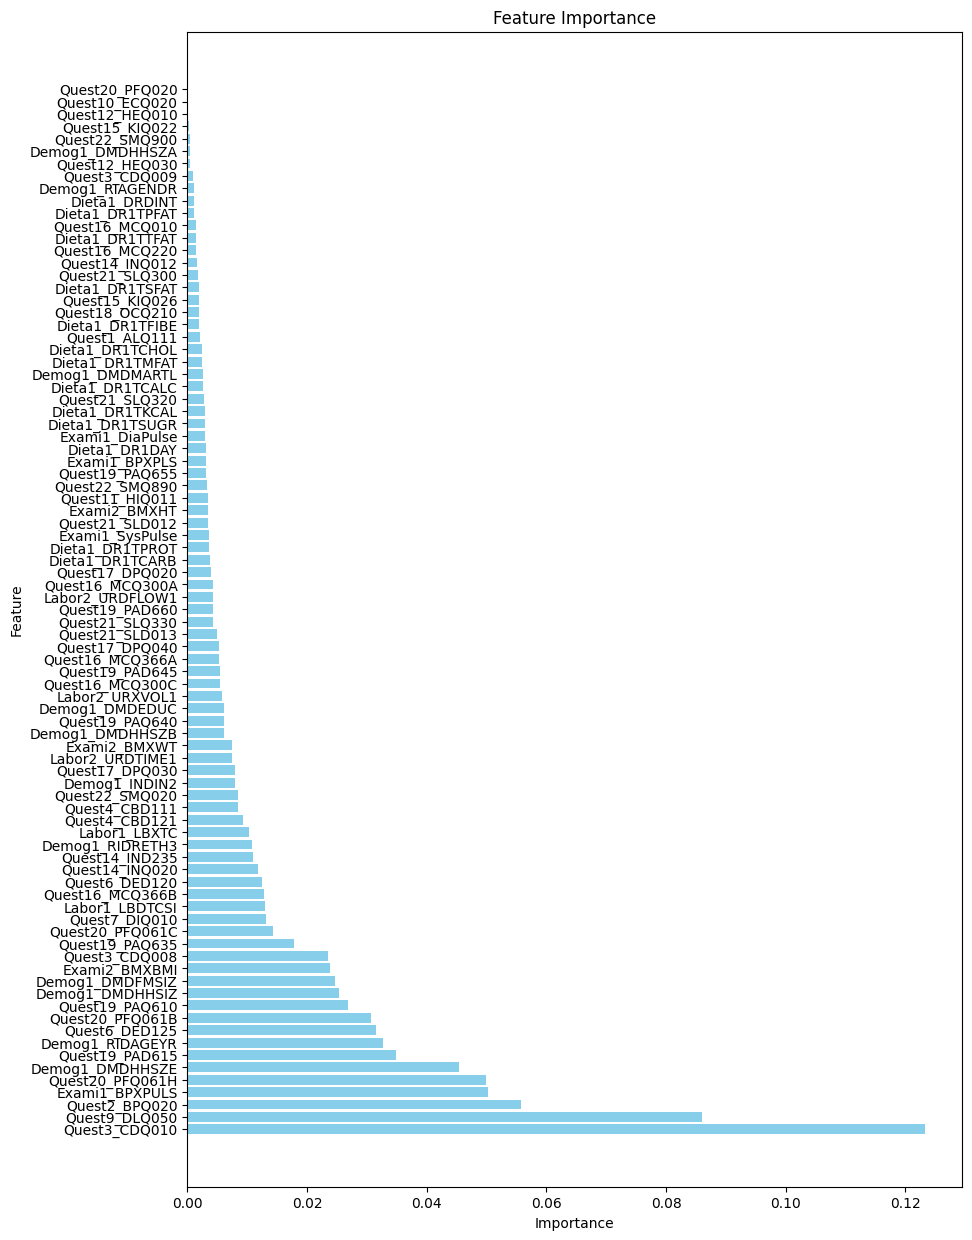

In [ ]:
np.random.seed(37)
random.seed(37)

worst_hyperparameters = grid_search.cv_results_['params'][np.argmax(grid_search.cv_results_['rank_test_score'] == np.max(grid_search.cv_results_['rank_test_score']))]

print("Worst Performing Hyperparameters:", worst_hyperparameters)

rf_classifier = RandomForestClassifier(**worst_hyperparameters)

rf_classifier.fit(X_train, y_train)

# Extract feature importance
feature_importances = rf_classifier.feature_importances_
col_list = X.columns

# Create a DataFrame to visualize feature importance
feature_importance_df = pd.DataFrame({'Feature': col_list, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 15))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

Best Performing Hyperparameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


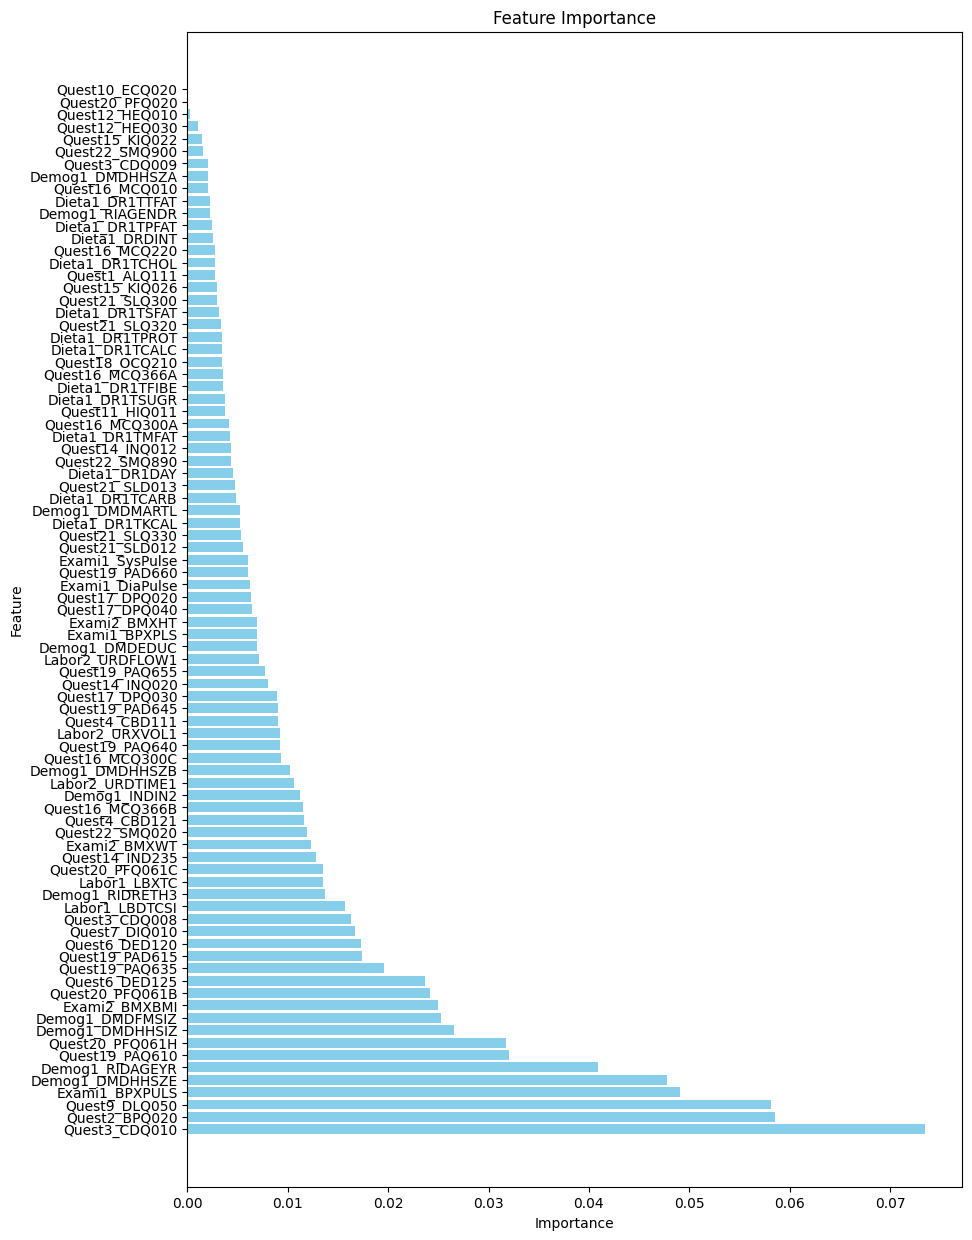

In [ ]:
np.random.seed(37)
random.seed(37)

best_hyperparameters = grid_search.cv_results_['params'][np.argmax(grid_search.cv_results_['rank_test_score'] == np.min(grid_search.cv_results_['rank_test_score']))]

print("Best Performing Hyperparameters:", best_hyperparameters)

rf_classifier = RandomForestClassifier(**best_hyperparameters)

rf_classifier.fit(X_train, y_train)

# Extract feature importance
feature_importances = rf_classifier.feature_importances_
col_list = X.columns

# Create a DataFrame to visualize feature importance
feature_importance_df = pd.DataFrame({'Feature': col_list, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 15))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()